In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os, warnings
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.utils.exceptions import AstropyWarning
import astropy.visualization as viz # MinMaxInterval, ImageNormalize, LinearStretch, ZScaleInterval, SqrtStretch, LogStretch
import astropy.coordinates as coords
import yaml
from hidefutils import id_to_name, mag_to_smass, normalize_image, jy_to_cm2, get_splus_phot

warnings.simplefilter('ignore', category=AstropyWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, message='converting a masked element to nan ')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "axes.linewidth": 1.5
})

In [224]:
import os
os.chdir('/mnt/scratch/HCGs')

In [2]:
df = get_splus_phot('HCG 91')

In [3]:
# df = pd.read_csv('phot_hcg91_splus.csv')
# x = df[df['ID'].str.lower() == 'dr4_3_splus-s23s33_0045811']
# float(x.RA)
df

ID,RA,DEC,g_auto,e_g_auto,r_auto,e_r_auto,radius,ab_ratio,i_auto,e_i_auto,PROB_GAL,zml,s2n_DET_auto
bytes26,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32
DR4_3_SPLUS-s20s33_0000317,330.9773708434365,-26.296844001167617,17.355795,0.01922549,16.976482,0.014910393,0.0008045725,1.1997381,16.863932,0.020922435,1.0,0.053083334,105.12958
DR4_3_SPLUS-s20s33_0000375,331.00765629135,-26.298347917513475,16.263828,0.21652173,15.739151,0.6904548,0.00095418916,1.1788647,15.510327,0.21229212,0.97,0.036666665,5.3745604
DR4_3_SPLUS-s20s33_0000711,331.26771753078793,-26.28584669324151,17.146637,0.012968309,16.305803,0.006965802,0.0010330213,2.480474,15.881299,0.007061864,0.97,0.057166666,230.60858
DR4_3_SPLUS-s20s33_0000744,330.9309265521243,-26.2837494803221,17.667751,0.022870164,16.812967,0.011836943,0.0008438655,1.9127687,16.385118,0.012396641,1.0,0.056166667,132.87604
DR4_3_SPLUS-s20s33_0001895,332.2315232821291,-26.2620481525345,16.879053,0.017881561,16.392338,0.012768036,0.0015961624,2.5022378,16.142227,0.015498061,1.0,0.030333333,124.225494
DR4_3_SPLUS-s20s33_0001924,331.2576763139017,-26.267904709812086,16.896194,0.01755614,16.232292,0.010713506,0.0012631706,1.6862282,15.852995,0.011737586,1.0,0.056833334,148.10457
...,...,...,...,...,...,...,...,...,...,...,...,...,...
DR4_3_SPLUS-s22s32_0058452,332.67018137737546,-27.896347380072594,14.915916,0.0030828293,14.208633,0.0018263749,0.0016601713,1.2504612,13.855275,0.0016784896,0.99,0.0285,983.81445
DR4_3_SPLUS-s22s32_0058661,333.1216773838738,-27.890336558882634,15.492204,0.00434982,14.717245,0.0024489583,0.0011260429,1.2571304,14.330537,0.0021875903,0.93,0.02925,736.4796


In [6]:
0.0010330213*3600

3.7188766799999997

In [225]:
def smass(hcgno):
    with open('data_files.yml') as f:
        grp_params = yaml.safe_load(f)
    dist = grp_params[f'HCG {hcgno}']['distance']

    df_output = pd.DataFrame(columns=['ID', 'Name', 'RA', 'Dec', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'radius_r', 'ba_ratio', 'radius_g', 'logMstar', 'e_logMstar'])
    id_dict = id_to_name(f'HCG {hcgno}')
    if str(hcgno) == '91':
        df_src = pd.read_csv('sources_h91.csv')
        ra, dec = df_src.ra, df_src.dec
        coo = coords.SkyCoord(ra, dec, unit=('deg', 'deg'), frame='fk5')
        df_splus  = pd.read_csv('phot_hcg91_splus.csv')
        sra, sdec = df_splus.RA, df_splus.DEC
        coo_splus = coords.SkyCoord(sra, sdec, unit=('deg', 'deg'), frame='fk5')
        idx, idxsplus, d2d, d3d = coords.search_around_sky(coo, coo_splus, 0.5*u.arcmin)
        id_uniq, id_cnt = np.unique(idx, return_counts=True)
        match_ids = np.zeros(id_uniq.size, dtype=int)
        for i, (id_, cnt) in enumerate(zip(id_uniq, id_cnt)):
            if cnt == 1:
                for j in range(len(idx)):
                    if idx[j] == id_:
                        match_ids[i] = idxsplus[j]
            else:
                m = idxsplus[idx==id_]
                d2d_ = d2d[idx==id_]
                mind2d = np.where(d2d_ == d2d_.min())
                match_ids[i] = m[mind2d[0][0]]
        sub_splus = df_splus.iloc[match_ids].reset_index(drop=True)
        sub_src = df_src.iloc[id_uniq].reset_index(drop=True)
        df_match = sub_src.join(sub_splus, rsuffix='_splus').drop(columns='sidelength(arcmin)').set_index('id')
        for i,galid in enumerate(df_match.index):
            galra, galdec = df_match.loc[galid].ra, df_match.loc[galid].dec
            rmag, gmag = df_match.loc[galid].r_auto, df_match.loc[galid].g_auto
            e_rmag, e_gmag = df_match.loc[galid].e_r_auto, df_match.loc[galid].e_g_auto
            radius = df_match.loc[galid].radius * 60
            ba_ratio = 1. / df_match.loc[galid].ab_ratio
            logms, e_logms = mag_to_smass(gmag=gmag, rmag=rmag, dist=dist, e_gmag=e_gmag, e_rmag=e_rmag)
            df_output.loc[i] = [galid, id_dict[galid], galra, galdec, gmag, e_gmag, rmag, e_rmag, radius, ba_ratio, np.nan, logms, e_logms]
        df_match.to_csv(f'photometry_match_hcg{hcgno}.csv', index=False)
    else:
        phot_r = pd.read_csv(f'desi_photometry/output/h{hcgno}_photometry_r.csv', index_col='ID')
        phot_g = pd.read_csv(f'desi_photometry/output/h{hcgno}_photometry_g.csv', index_col='ID')
        for i,galid in enumerate(id_dict.keys()):
            try:
                rmag, gmag = phot_r.loc[galid].petroMag, phot_g.loc[galid].petroMag
                radius_r, radius_g = phot_r['R25(arcsec)'].loc[galid]/60., phot_g['R25(arcsec)'].loc[galid]/60.
                ba_ratio = phot_r['b/a'].loc[galid]
            except KeyError:
                print('--- HCG %s: %s' %(hcgno, galid))
            else:
                galra, galdec = phot_r.loc[galid].RAobj, phot_r.loc[galid].DECobj
                e_rmag, e_gmag = phot_r.loc[galid].petroMag_err, phot_g.loc[galid].petroMag_err
                logms, e_logms = mag_to_smass(gmag=gmag, rmag=rmag, dist=dist, e_gmag=e_gmag, e_rmag=e_rmag)
                df_output.loc[i] = [galid, id_dict[galid], galra, galdec, gmag, e_gmag, rmag, e_rmag, radius_r, ba_ratio, radius_g, logms, e_logms]
    df_output.to_csv(f'stellar_masses_h{hcgno}.csv', index=False)
    return df_output

In [226]:
for hcg in [16, 30, 31, 90, 91, 97]:
    smass(hcg)

In [19]:
df = smass(91)
df

,ID,Name,RA,Dec,gmag,e_gmag,rmag,e_rmag,radius_r,ba_ratio,radius_g,logMstar,e_logMstar
0,WJ221040_274144,WISEA J221040.40-274144.2,332.66825,-27.69573,17.965322,0.028135,17.537453,0.019879,0.066462,0.328285,NaN,8.843968,0.037476
1,AP_B220902,APMUKS(BJ) B220902.13-282233.7,332.96841,-28.12878,16.027336,0.010815,15.541443,0.006613,0.170717,0.255516,NaN,9.706023,0.016633
2,WJ220732_274450,WISEA J220732.99-274450.6,331.88767,-27.74772,18.600077,0.046400,18.146317,0.031746,0.035855,0.712149,NaN,8.628824,0.059786
3,ESO467_G016,ESO 467- G 016,332.45925,-27.53561,14.526571,0.003186,13.875488,0.002393,0.133996,0.733822,NaN,10.553618,0.010838
4,WJ220835_274743,WISEA J220835.52-274743.6,332.14757,-27.79523,16.972094,0.016730,16.696423,0.013441,0.108471,0.351202,NaN,9.013418,0.024620
5,HCG91C,HCG 91C,332.30838,-27.78219,14.586775,0.005389,14.059366,0.003480,0.166721,0.921218,NaN,10.344396,0.012051
6,WJ220834_281601,WISEA J220834.52-281601.1,332.14398,-28.26715,16.822212,0.022321,16.393845,0.015464,0.089633,0.834906,NaN,9.301957,0.030175
7,IC5168,IC 5168,332.18975,-27.85647,15.306389,0.007407,14.853100,0.005071,0.234520,0.331015,NaN,9.945594,0.013732
8,ESO467_G015,ESO 467- G 015,332.31779,-27.73033,14.758142,0.003482,14.015005,0.001950,0.198351,0.222407,NaN,10.598794,0.010840
9,ESO532_G022,ESO 532- G 022,332.29696,-27.16642,14.817052,0.007744,14.362139,0.006668,0.180526,0.862108,NaN,10.143760,0.014654


In [16]:
0.198351*60

11.90106

/opt/conda/envs/hidef/lib/python3.11/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


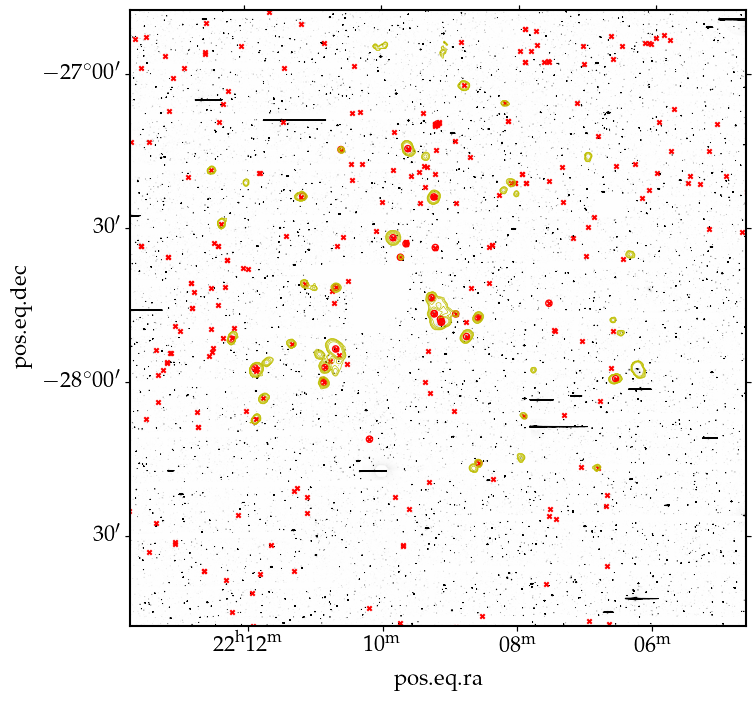

In [7]:
with open('group_members.yml') as f:
    group_members = yaml.safe_load(f)
with open('data_files.yml') as f:
        params = yaml.safe_load(f)

g = 'HCG 91'
grz, opthdr = fits.getdata('/mnt/scratch/HCGs/legacy_images/%s_grz.fits' %g.replace(' ',''), header=True)
grz_normalized = [normalize_image(image, contrast=1e-4, stretch_func='log', a=50) for image in grz]
grz_normalized.reverse()

df_splus  = pd.read_csv('phot_%s_splus.csv' %g.replace(' ','').lower())
sra, sdec = df_splus.RA, df_splus.DEC

rgb_image = np.stack(grz_normalized, axis=-1)
levs = [6.6e18 * 2**x for x in range(5)]
optwcs = WCS(opthdr).celestial

fits_m0 = params[g]['rootdir'] + '/' + params[g]['moment_0']
hidata, hihdr = fits.getdata(fits_m0, header=True)
hiwcs = WCS(hihdr)
nhi = jy_to_cm2(hidata,hihdr)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=optwcs)
if g == 'HCG 91':
    image = grz[0]
    ax.imshow(image, origin='lower', cmap='gray_r', norm=viz.ImageNormalize(image, interval=viz.PercentileInterval(99.), stretch=viz.SinhStretch(0.5)))
    ax.contour(nhi, levels=levs, linewidths=0.5, colors='y', transform=ax.get_transform(hiwcs))
else:
    ax.imshow(rgb_image, origin='lower')
    ax.contour(nhi, levels=levs, linewidths=0.5, colors='w', transform=ax.get_transform(hiwcs))
ax.scatter(sra, sdec, c='r', marker='x', s=10, transform=ax.get_transform('world'))
ax.set_xlim(0, rgb_image.shape[0])
ax.set_ylim(0, rgb_image.shape[1])
match_ra, match_dec = df_output.RA, df_output.Dec
ax.scatter(match_ra, match_dec, ec='r', fc='None', marker='o', s=20, transform=ax.get_transform('world'))
plt.savefig('splus_matches.pdf')
plt.show()

In [43]:
from astroquery.vizier import Vizier

In [47]:
with open('morphologies.yml') as f:
    md = yaml.safe_load(f)
for key in md.keys():
    print(key,'--')
    m = md[key]
    for s in m:
        if not m[s]:
            t = Vizier.query_object(s, catalog='VII/237')
            morph = t[0]['MType'][0]
            print(s,':', morph)

HCG 16 --
HCG 30 --
NGC 1618 : SBb
NGC 1622 : SBab
NCG 1625 : SBb
FGC 0495 : Scd
HCG 31 --
HCG 90 --
ESO 466- G 036 : Sa
ESO 404- G 027 : SBc
ESO 404- G 018 : SBcd
NGC 7163 : 
ESO 466- G 046 : SO-a
ESO 466- G 047 : Sbc
ESO 466- G 044 : E-SO
ESO 466- G 051 : SO-a
2dFGRS S408Z037 : SBc
ESO 404- G 028 : Sa
HCG 91 --
ESO 467- G 016 : Sa
ESO 467- G 014 : 
IC 5168 : SBc
WISEA J221051.42-280016.7 : Sc
ESO 467- G 003 : 
ESO 467- G 005 : Sb
ESO 532- G 023 : SBbc
WISEA J220913.03-273402.8 : E
ESO 532- G 022 : SBc
APMUKS(BJ) B220922.77-280636.6 : 
APMUKS(BJ) B220902.13-282233.7 : 
WISEA J220839.75-281703.5 : 
HCG 97 --


In [54]:
t= Vizier.query_object('NGC 7163', catalog='VII/237')
t[0]

PGC,RAJ2000,DEJ2000,OType,MType,logD25,logR25,PA,ANames
,,,,,log(0.1arcmin),,deg,
int32,str10,str9,str2,str5,float32,float32,float32,str255
700107,21 59 19.8,-31 51 48,G,,0.63,0.23,127.0,
67785,21 59 20.5,-31 52 59,G,SBab,1.33,0.32,100.0,NGC7163 ESO466-30 MCG-5-51-035 ESO-LV4660300 IRAS21564-3207 DUKST466-2
